In [17]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import torch
import pathlib
from pathlib import Path
import PixelEncoder
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import math
from math import sqrt

import PixelEncoder
from PixelEncoder import PixelEncodingSet, Segments

In [18]:
data_path = Path(
    f"/Users/mary/Documents/School/Sketch Simplification/Sketch-Simplification/dataset"
)

In [19]:
class SketchData(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for image and JSON pairs.

    Args:
        root_dir (str): Path to the root directory containing image folders.
        transform (callable, optional): A function/transform to apply to the image.
    """

    def __init__(self, targ_dir, transform=None):
        self.paths = list(targ_dir.glob("*/."))

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."

        data_path = self.paths[index]

        img = Image.open(data_path / Path("base.png"))

        if self.transform:
            # return data, label (X, y)
            return self.transform(img), index
        else:
            return img, index

    def getOtherData(self, index: int):
        data_path = self.paths[index]
        pixe_set = PixelEncodingSet.load(data_path / Path("pixe_set.json"))
        segs = Segments.load(data_path / Path("segs.json"), fromBlender=False)
        return pixe_set, segs


data = SketchData(targ_dir=data_path)
data.getOtherData(0)

(<PixelEncoder.PixelEncodingSet at 0x293105420>,
 <PixelEncoder.Segments at 0x293428250>)

In [20]:
# Global params


T = 10

BATCH_SIZE = 1

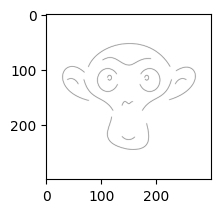

In [21]:
def show_images(data, num_samples=20, cols=4):
    """Plots some samples from the dataset"""
    plt.figure(figsize=(15, 15))
    for i, img_data in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples / cols) + 1, cols, i + 1)
        plt.imshow(img_data[0])


show_images(data)

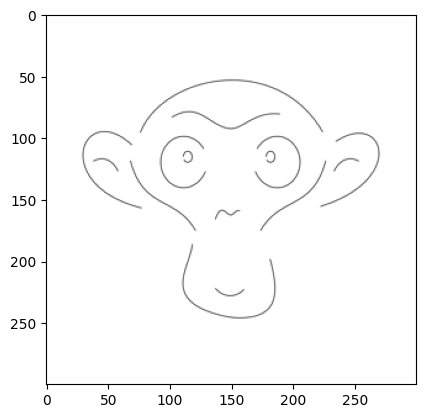

In [22]:
# Transform data

IMG_SIZE = 10, 10


def load_transformed_dataset():

    data_transforms = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    train = SketchData(data_path, transform=data_transforms)

    # TODO make data split so that we aren't using duplicate data
    test = SketchData(data_path, transform=data_transforms)
    return train


def show_tensor_image(image):
    reverse_transforms = transforms.Compose(
        [
            transforms.ToPILImage(),
        ]
    )

    plt.imshow(reverse_transforms(image))


data = load_transformed_dataset()
show_tensor_image(data[0][0])

TypeError: 'Image' object is not subscriptable

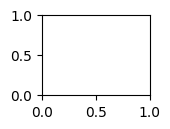

In [25]:
def forward_diffusion_sample(img0_data, t, device="cpu"):
    img0, img_index = img0_data
    pixe_set, segs = data.getOtherData(img_index)

    segs1 = PixelEncoder.generateSketchSegs(segs, t)

    return pixe_set.img(segs1), 0


num_images = 1

# print(data[0])
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)


image_data = next(iter(dataloader))

for idx in range(0, T):
    t = torch.Tensor([idx]).type(torch.int64)

    plt.subplot(int(sqrt(T)) + 1, int(sqrt(T)) + 1, idx + 1)
    # plt.axis(False)
    img, noise = forward_diffusion_sample(image_data, idx / T)
    show_tensor_image(img)

plt.show()